In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import shap
import matplotlib.pyplot as plt

# Re-load data & models
df   = pd.read_parquet(Path("../data/processed/hvbp_2025_clean.parquet"))
X    = df[["wt_clinical","wt_pce","wt_safety","wt_efficiency"]].fillna(0)
xgb  = joblib.load("../models/tps_topquartile_xgb.pkl")
linr = joblib.load("../models/tps_linear.pkl")         


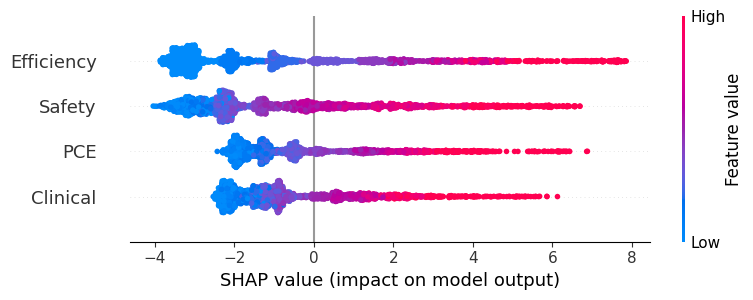

In [2]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

shap.summary_plot(
    shap_values, X,
    feature_names=["Clinical","PCE","Safety","Efficiency"],
    show=False 
)
plt.tight_layout()
plt.savefig("../figures/xgb_shap_summary.png", dpi=150)
plt.show()


### Across all 2 489 hospitals, big Efficiency scores create the biggest upward shove toward elite status; Safety is second-largest—when it’s available.

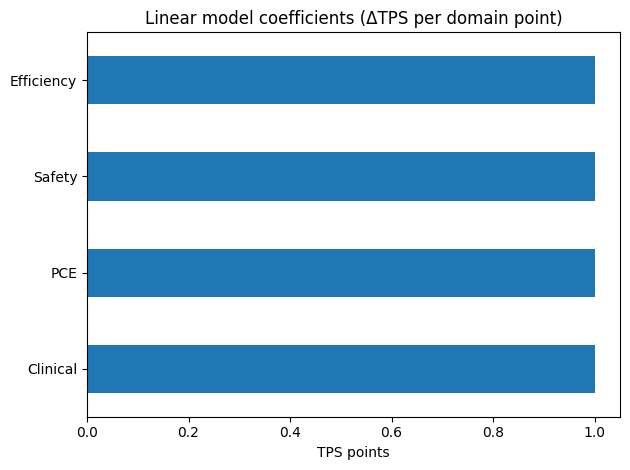

In [3]:
coef = pd.Series(linr.coef_,
                 index=["Clinical","PCE","Safety","Efficiency"])
coef.plot.barh()
plt.title("Linear model coefficients (ΔTPS per domain point)")
plt.xlabel("TPS points")
plt.tight_layout()
plt.savefig("../figures/linr_coef_bar.png", dpi=150)
plt.show()


In [4]:
def explain_hospital(fac_id):
    row = df.loc[df["Facility ID"] == fac_id]
    X_row = row[["wt_clinical","wt_pce","wt_safety","wt_efficiency"]].fillna(0)
    base   = explainer.expected_value
    shap_r = explainer.shap_values(X_row)
    shap.waterfall_plot(
        shap.Explanation(values=shap_r[0],
                         base_values=base,
                         data=X_row.values[0],
                         feature_names=["Clinical","PCE","Safety","Efficiency"]),
        show=False
    )
    plt.title(f"Why is {row['Facility Name'].iat[0]} top-quartile?")
    plt.tight_layout()
   
    return row['Facility Name'].iat[0]  

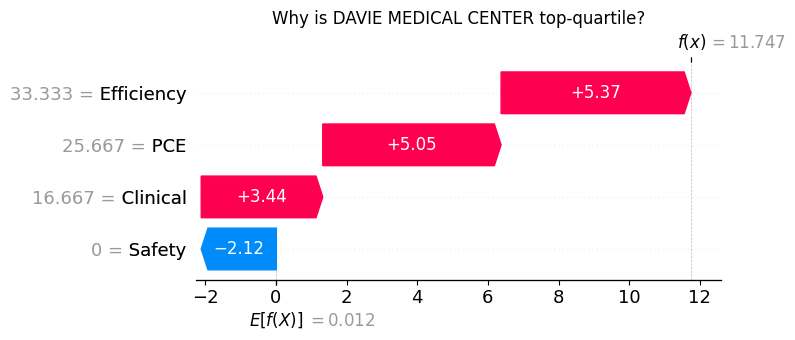

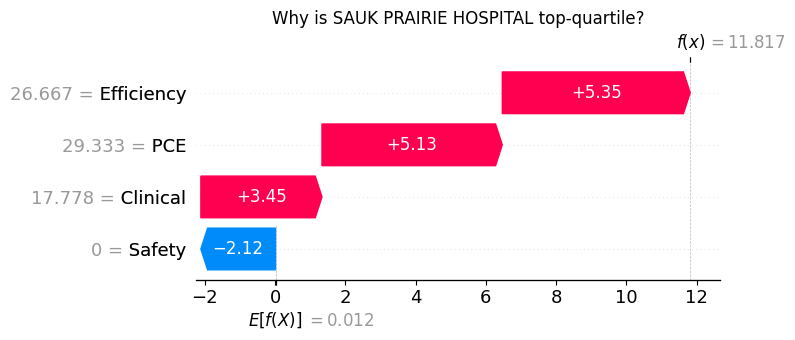

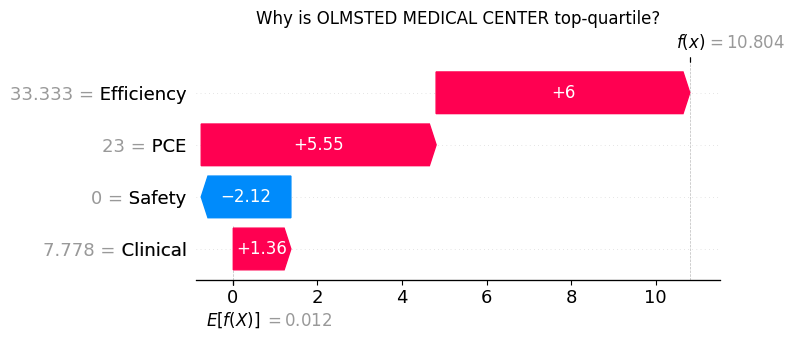

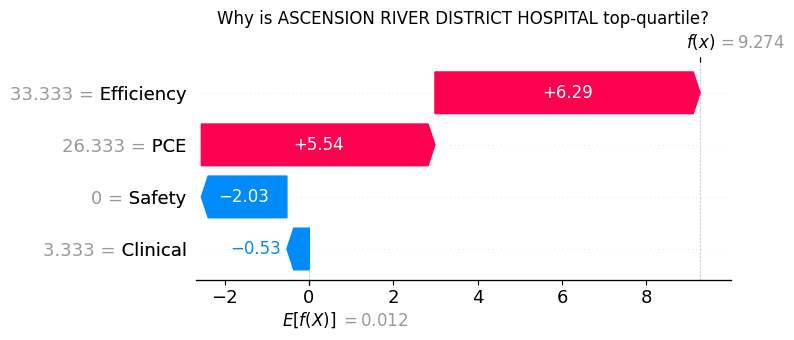

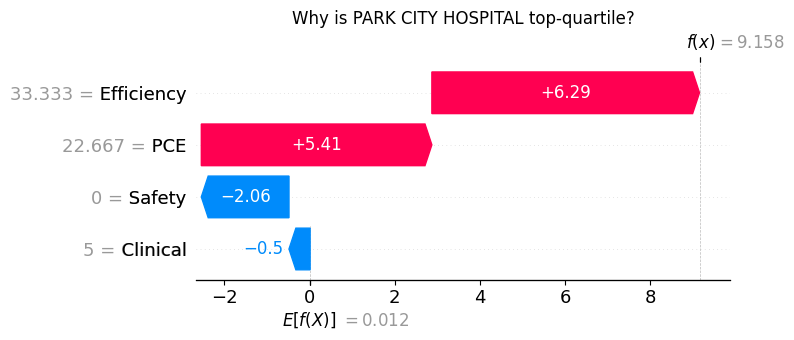

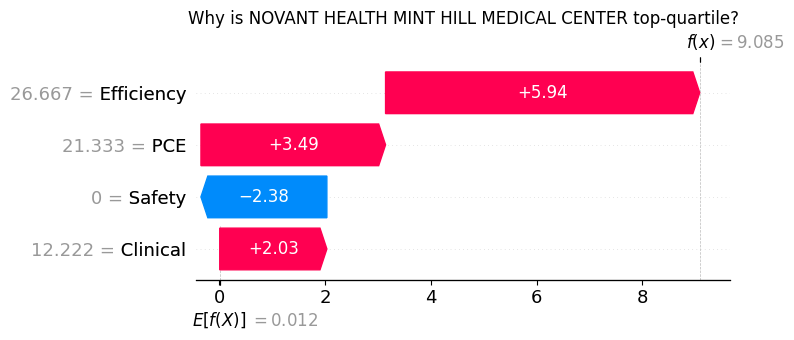

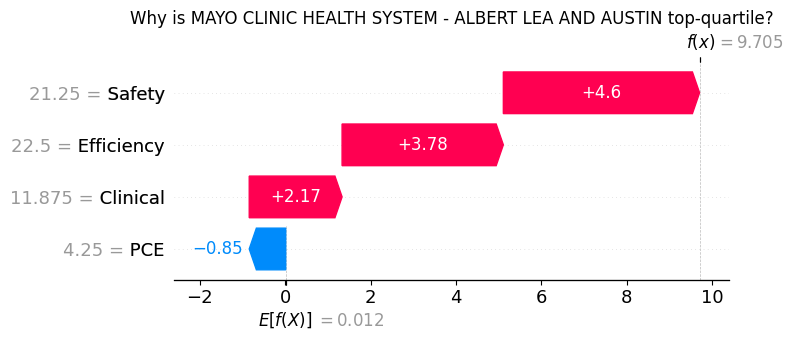

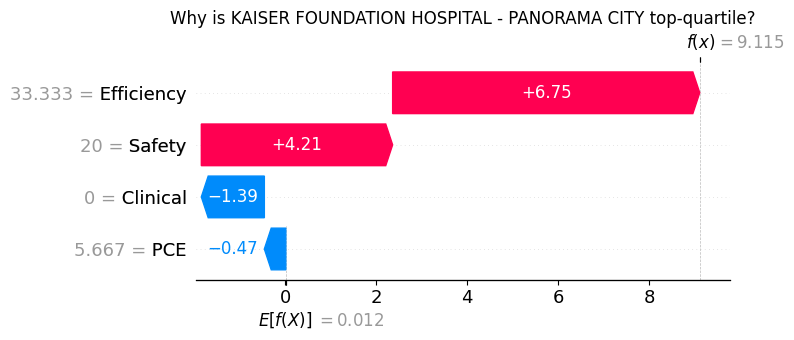

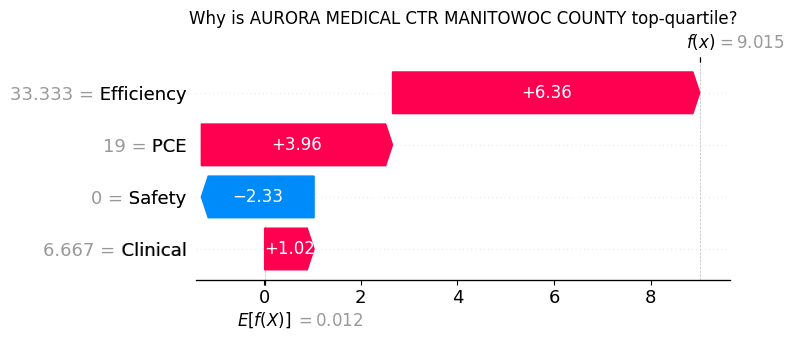

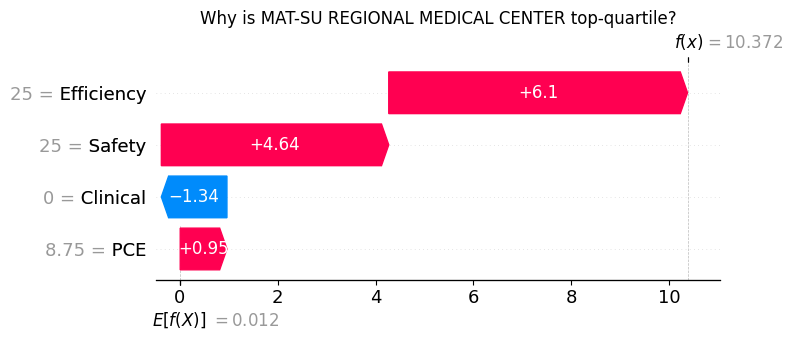

In [5]:

top10_ids = df.nlargest(10, "tps")["Facility ID"]
for fac in top10_ids:
    facility_name = explain_hospital(fac)
    plt.savefig(f"../figures/waterfall_{fac}.png", dpi=150, bbox_inches='tight')
    plt.show()  
    plt.close()  

# Pattern across all ten
### High Efficiency is the universal ticket to the top; Safety is a big bonus when present, but hospitals without it can still excel by pairing elite Efficiency with standout PCE (and, to a lesser extent, Clinical Outcomes).